In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from sklearn import preprocessing
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.preprocessing import StandardScaler 
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier #Random Forest 

from sklearn.preprocessing import OneHotEncoder 


import keras
import keras.layers as layers
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.losses import sparse_categorical_crossentropy 
import tensorflow_addons as tfa

import itertools
from keras.layers import LSTM


import joblib
import os 
from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import matplotlib.pyplot as plt

# Neural Network Creation

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

df = pd.read_csv('full_dataset.csv')
print(df.head())

environment_encoder = pd.get_dummies(df['Environment'])
df = df.join(environment_encoder)
df = df.drop(['Environment', 'Unnamed: 0'], axis = 1)
df.info()

   Unnamed: 0  AntennaLat  AntennaLon Environment  population_dens  No_Data  \
0           0   31.905179 -106.575334           i        13.823619      0.0   
1           1   31.905179 -106.575334           i        12.776135      0.0   
2           2   33.311727 -104.515592           u       120.123110      0.0   
3           3   31.905245 -106.575092           i        15.653808      0.0   
4           4   31.905245 -106.575092           i        15.988421      0.0   

      Water  Trees     Grass  Flooded Vegetation     Crops  Scrub/Shrub  \
0  0.000000    0.0  0.000000                 0.0  0.000000     0.010608   
1  0.000000    0.0  0.000000                 0.0  0.000000     0.000000   
2  0.001198    0.0  0.000568                 0.0  0.129851     0.554364   
3  0.000000    0.0  0.000000                 0.0  0.000000     0.026833   
4  0.000000    0.0  0.000000                 0.0  0.000000     0.000000   

   Built_Area  Bare_Ground  Snow/Ice  Clouds  median_height  stdDev_height

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['d', 'i', 'r', 's', 't', 'u'], axis = 1), df[['d', 'i', 'r', 's', 't', 'u']], test_size = 0.2)
x_trainLocation = x_train[['AntennaLat', 'AntennaLon']]
x_testLocation = x_test[['AntennaLat', 'AntennaLon']]
x_train = x_train.drop(['AntennaLat', 'AntennaLon'], axis = 1)
x_test = x_test.drop(['AntennaLat', 'AntennaLon'], axis = 1)

In [4]:
# clf = RandomForestClassifier(n_estimators = 50, max_depth = 20, min_samples_split = 10, min_samples_leaf = 3, bootstrap = True, criterion = 'gini', max_features = 'sqrt')

# kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

# scores = cross_val_score(clf, x_train, y_train, cv = 5, scoring = 'f1_macro', n_jobs = -1); 

# print(scores)
df.info(verbose = True, show_counts = True); 
# df.to_csv('full_dataset.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711347 entries, 0 to 2711346
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AntennaLat             2711347 non-null  float64
 1   AntennaLon             2711347 non-null  float64
 2   population_dens        2711347 non-null  float64
 3   No_Data                2711347 non-null  float64
 4   Water                  2711347 non-null  float64
 5   Trees                  2711347 non-null  float64
 6   Grass                  2711347 non-null  float64
 7   Flooded Vegetation     2711347 non-null  float64
 8   Crops                  2711347 non-null  float64
 9   Scrub/Shrub            2711347 non-null  float64
 10  Built_Area             2711347 non-null  float64
 11  Bare_Ground            2711347 non-null  float64
 12  Snow/Ice               2711347 non-null  float64
 13  Clouds                 2711347 non-null  float64
 14  median_height     

In [5]:
x_train, y_train, x_test, y_test = x_train.values, y_train.values, x_test.values, y_test.values

In [6]:
print(x_train.shape)
model = keras.Sequential() 
model.add(Dense(10000, activation = 'relu', input_shape = (x_train.shape[1],)))
model.add(Dense(5000, activation = 'relu', input_shape = (x_train.shape[1],)))
model.add(Dense(6, activation = 'softmax'))

(2169077, 16)



In [8]:
f1 = tfa.metrics.F1Score(6, 'macro')
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [f1, 'accuracy'])
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(x_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2, callbacks = [early_stop, model_checkpoint_callback])

Epoch 1/30
   46/27114 [..............................] - ETA: 3:14:48 - loss: 0.7961 - f1_score: 0.1646 - accuracy: 0.7823

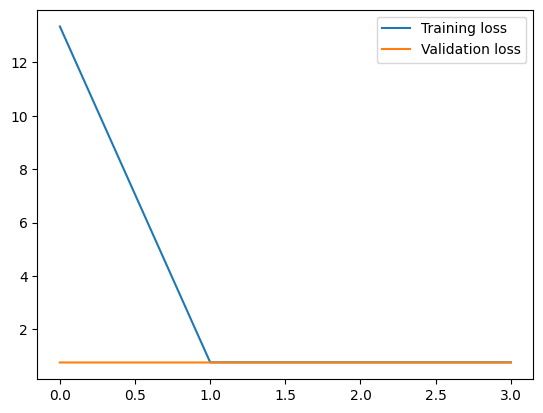

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(x_test)

25561/25561 [==============================] - 26s 1ms/step


In [ ]:
from sklearn.metrics import f1_score 
print(f1_score(y_test, predictions, average = 'macro'))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
# EXPORTING THE MODEL TO YOUR

import joblib 
joblib.dump(model, 'neural_net.pkl', compress = 9)

['randomForest_2.pkl']

In [ ]:

incorrect_indices = np.where(y_test != predictions)[0]

y_test_defined = y_test.map(lambda x: definitions[x])
y_test_pred_defined = pd.DataFrame(predictions, columns = ['Predicted_Environment'])
y_test_pred_defined = y_test_pred_defined.map(lambda x: definitions[x])

y_test_defined.reset_index(drop=True, inplace=True) 
y_test_pred_defined.reset_index(drop=True, inplace=True)
x_testLocation.reset_index(drop=True, inplace=True)

predict_df = pd.concat([x_test, x_testLocation, y_test_defined], axis = 1)   
predict_df = pd.concat([predict_df, y_test_pred_defined], axis = 1)

incorrect_predictions = predict_df.iloc[incorrect_indices]

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
incorrect_predictions.to_csv(r'C:\\Users\\Thomas\Documents\\GitHub\ML\\Land_Classification_CNN\\data\\Prediction_Differences\\incorrect_predictions.csv')